In [34]:
import numpy as np
import pandas as pd 

import os
import re

import missingno as msno 
import string 
import seaborn as sns 
import matplotlib.pyplot as plt

import scipy.optimize as opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import scipy.stats as sps

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
cve = pd.read_csv('cve_cleaned.csv', header=0, index_col=0)
products = pd.read_csv('data/products.csv', header=0, index_col=0)
vendors = pd.read_csv('data/vendors.csv', header=0, index_col=0)

In [3]:
cve.describe()

,cvss,cwe_code,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity
count,87613.000000,87613.000000,87613.000000,87613.000000,87613.000000,87613.000000,87613.000000,87613.000000
mean,6.014371,198.705535,0.136190,0.510027,0.916359,0.858548,0.859313,0.898725
std,1.990095,174.893554,0.343757,0.551842,0.369274,0.757287,0.711916,0.681782
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,79.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,5.800000,119.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,7.500000,284.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,1188.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [4]:
cve.mod_date = pd.to_datetime(cve.mod_date)
cve.pub_date = pd.to_datetime(cve.pub_date)

In [5]:
def getMonth(pub_date):
    return(pub_date.strftime('%B'))
 
def getYear(pub_date):
    return(pub_date.strftime('%Y'))
 
# Applying the month and year extractor functions
cve['month']=cve['pub_date'].apply(getMonth)
cve['year']=cve['pub_date'].apply(getYear)

In [6]:
z = cve['month'].value_counts()

z1 = z.to_dict() #converts to dictionary

cve['count'] = cve['month'].map(z1)

In [7]:
months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
cve["month"] = pd.Categorical(cve["month"], categories = months_categories)
cve = cve.sort_values(by = ["month", "year"])

In [29]:
cve = cve.astype({"year": int})

In [8]:
cve.head()

,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,month,year,count
CVE-1999-0349,2018-10-12 21:29:00,1999-01-27 05:00:00,7.5,119,Improper Restriction of Operations within the...,A buffer overflow in the FTP list (ls) command...,0,0,1,1,1,1,January,1999,6308
CVE-1999-0348,2018-08-13 21:47:00,1999-01-27 05:00:00,5.0,200,Information Exposure,IIS ASP caching problem releases sensitive inf...,0,0,1,0,1,0,January,1999,6308
CVE-1999-0656,2017-07-11 01:29:00,1999-01-01 05:00:00,5.0,16,Configuration,"The ugidd RPC interface, by design, allows rem...",0,0,1,0,1,0,January,1999,6308
CVE-1999-0226,2017-05-03 16:18:00,1999-01-01 05:00:00,10.0,19,Data Processing Errors,Windows NT TCP/IP processes fragmented IP pack...,0,0,1,2,2,2,January,1999,6308
CVE-1999-0453,2008-09-05 20:17:00,1999-01-01 05:00:00,5.0,200,Information Exposure,An attacker can identify a CISCO device by sen...,0,0,1,0,1,0,January,1999,6308


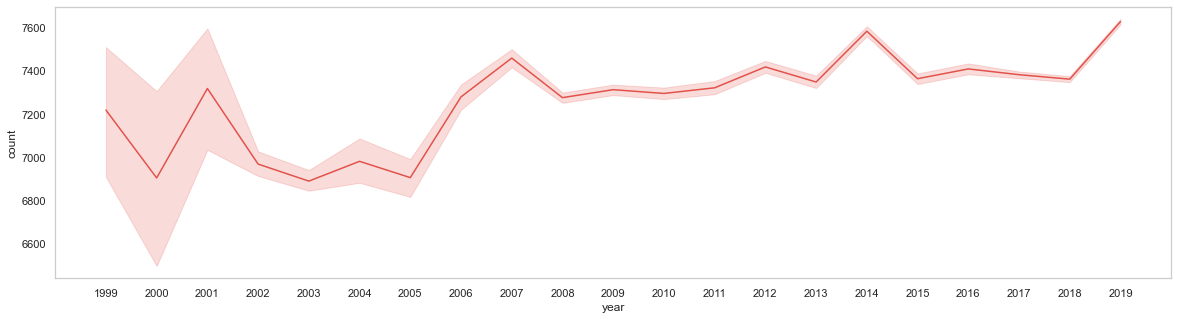

In [9]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot('year', 'count', data=cve)

Clearly, this is not a stationary process, and it is hard to tell if there is some kind of seasonality.

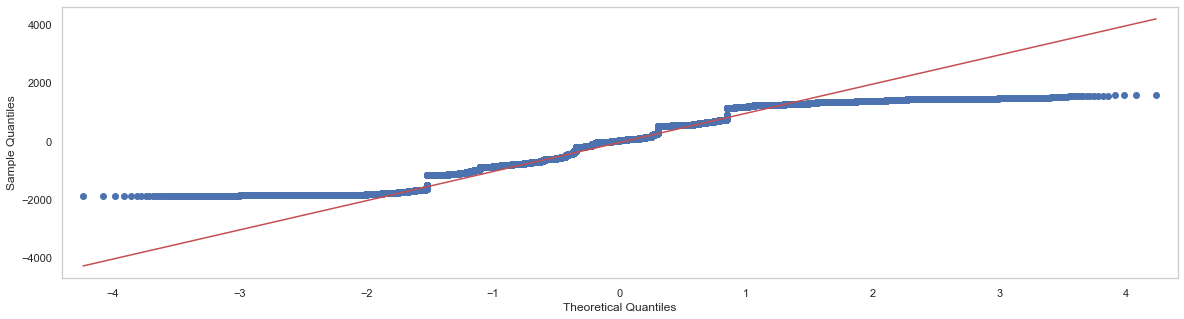

In [30]:
X = sm.add_constant(cve['year'])
model = sm.OLS(cve['count'], X).fit()
residuals = model.resid
qq_plot = sm.qqplot(residuals, line='q')
plt.show()

In [31]:
X = sm.add_constant(cve['year'])
model = sm.OLS(cve['count'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     565.3
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.49e-124
Time:                        11:37:02   Log-Likelihood:            -7.1912e+05
No. Observations:               87613   AIC:                         1.438e+06
Df Residuals:                   87611   BIC:                         1.438e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.863e+04   1515.862    -18.885      0.0

(array([5.6010e+03, 7.0000e+00, 9.6070e+03, 1.4494e+04, 6.1740e+03,
        1.6969e+04, 7.7020e+03, 9.7250e+03, 7.2700e+03, 1.0064e+04]),
 array([-1883.04207642, -1536.86316976, -1190.6842631 ,  -844.50535644,
         -498.32644978,  -152.14754312,   194.03136354,   540.2102702 ,
          886.38917686,  1232.56808352,  1578.74699018]),
 <a list of 10 Patch objects>)

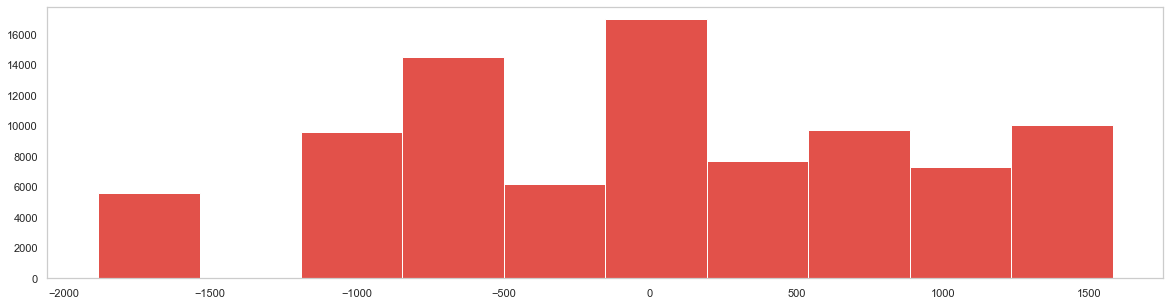

In [32]:
X = sm.add_constant(cve['year'])
model = sm.OLS(cve['count'], X).fit()
residuals = model.resid
plt.hist(residuals)

**Moving average**

Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

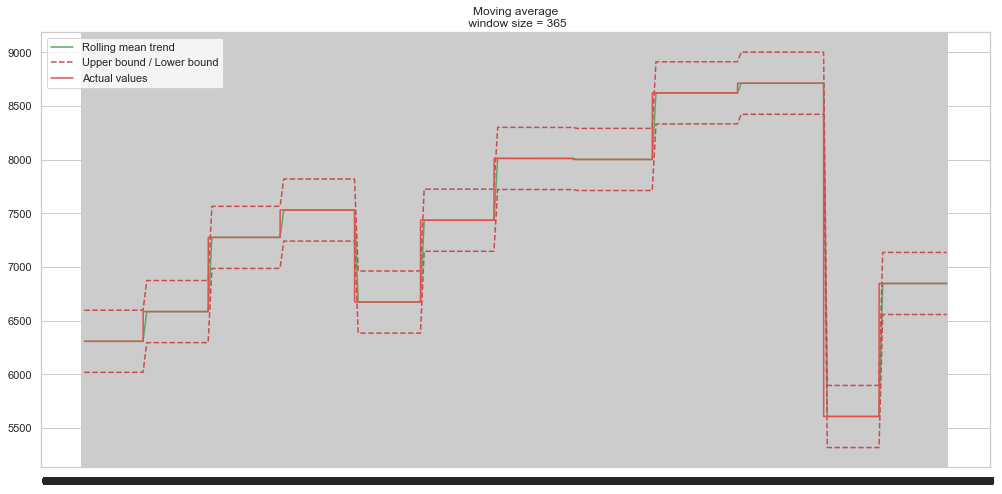

In [11]:
# Smooth by year
plot_moving_average(cve['count'], 365, plot_intervals=True)

***
**Exponential smoothing**
***

In [12]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [13]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

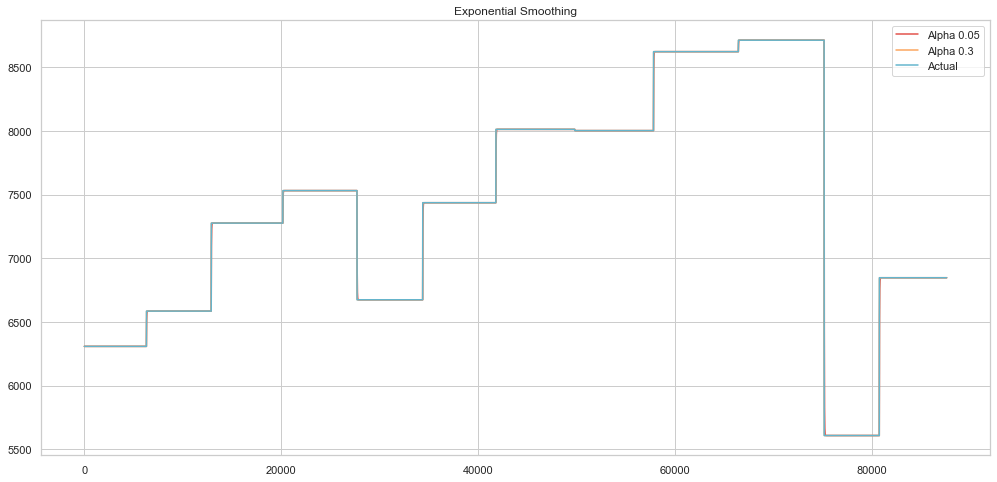

In [14]:
plot_exponential_smoothing(cve['count'], [0.05, 0.3])

***
**Double exponential smoothing**
***

In [15]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [16]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

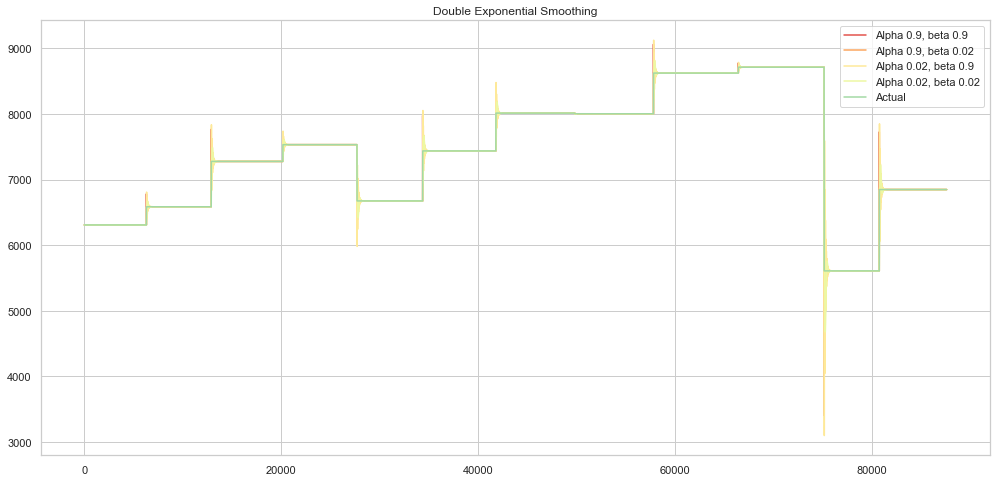

In [18]:
plot_double_exponential_smoothing(cve['count'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

***
**Stationarity**
***

Stationarity is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.

In [19]:
cve_gr = pd.DataFrame({'count' : cve.groupby( [ "year", "month"] ).size()}).reset_index()

In [20]:
cve_gr['count'] = cve_gr['count'].replace(0, 1)

**Time series decomposition plot**

The time series decomposition plot provides a useful model for thinking about time series. Decomposition assumes that a time series can be broken down into a combination of the following components:
- level — the average value of the series,
- trend — an increasing/decreasing pattern in the series,
- seasonality — a repeating short-term cycle in the series,
- noise — the random, unexplainable variation.

While all time series have the level and noise components, while the trend and seasonality are optional.

What is left to add is that there are two main types of decomposition models:
- additive — it assumes that the components above are added together (linear model). The changes over time are more or less constant.
- multiplicative — it assumes that the components are multiplied by each other. Hence, the changes over time are non-linear and not constant, so they can increase/decrease with time. An example could be exponential growth.

For our case, when looking at the time plot we can now see that there seems to be a monthly seasonality and the changes over time are not constant (increasing), so we will go with the multiplicative model.

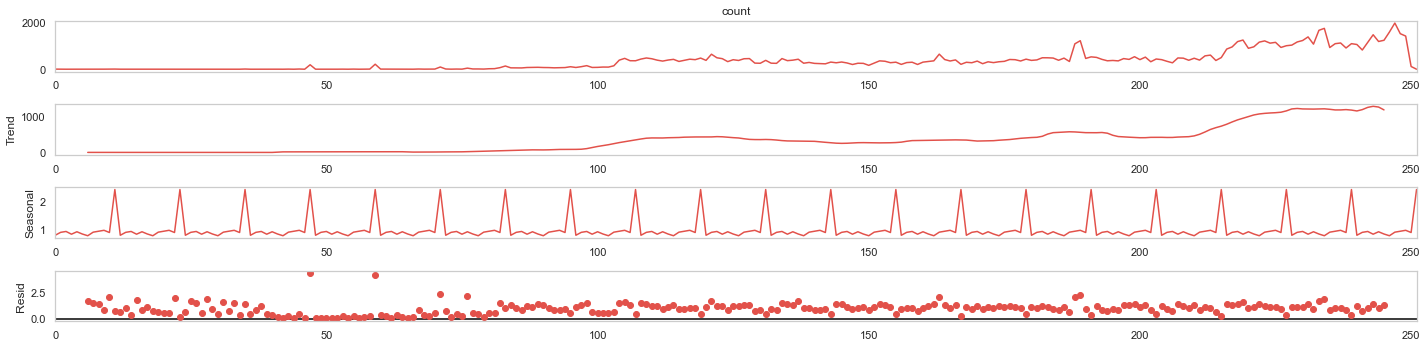

In [21]:
decomposition = seasonal_decompose(cve_gr['count'], 
                                   model='multiplicative', 
                                   period=12)
decomposition.plot();

In the plot we see the actual series in the first part, then the trend component, the seasonal one, and lastly the residuals (error term). 

The residuals in the multiplicative model suggest a good fit (they should be close to 0 for the additive one).

As always with automatic approaches, we should do a simple sanity check and do not trust the results blindly. For this simple example, we can see the confirmation of what we initially suspected about the time series.

**Autocorrelation plots**

When measuring the correlation between the time series and its lagged values (from previous points in time) we are talking about autocorrelation. There are two types of autocorrelation plots we can use.

The **autocorrelation function (ACF)** shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.

In contrast, the **partial autocorrelation function (PACF)** looks at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

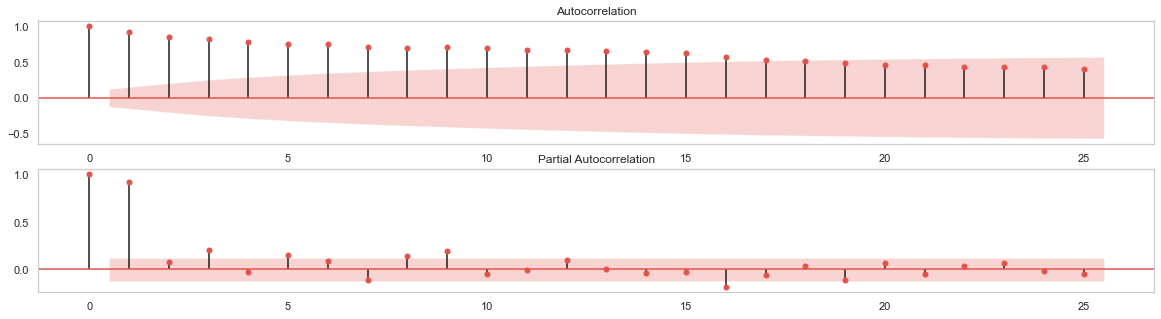

In [22]:
fig, ax = plt.subplots(2)
plot_acf(cve_gr['count'], ax=ax[0])
plot_pacf(cve_gr['count'], ax=ax[1]);

In the ACF plot, we can see that there are significant autocorrelations (above the 95% confidence interval, corresponding to the default 5% significance level). There are also some significant autocorrelations in the PACF plot.

Normally, the autocorrelations plots are often used for determining the stationarity of the time series or choosing the hyperparameters of the ARIMA class models.

In [35]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(cve['count'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.223145146882404
p-value: 0.19795259264074616


In [36]:
# Take the log difference to make data stationary

cve['count'] = np.log(cve['count'])
cve['count'] = cve['count'].diff()
cve = cve.drop(cve.index[0])
cve.head()

,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,month,year,count
CVE-1999-0348,2018-08-13 21:47:00,1999-01-27 05:00:00,5.0,200,Information Exposure,IIS ASP caching problem releases sensitive inf...,0,0,1,0,1,0,January,1999,0.0
CVE-1999-0656,2017-07-11 01:29:00,1999-01-01 05:00:00,5.0,16,Configuration,"The ugidd RPC interface, by design, allows rem...",0,0,1,0,1,0,January,1999,0.0
CVE-1999-0226,2017-05-03 16:18:00,1999-01-01 05:00:00,10.0,19,Data Processing Errors,Windows NT TCP/IP processes fragmented IP pack...,0,0,1,2,2,2,January,1999,0.0
CVE-1999-0453,2008-09-05 20:17:00,1999-01-01 05:00:00,5.0,200,Information Exposure,An attacker can identify a CISCO device by sen...,0,0,1,0,1,0,January,1999,0.0
CVE-1999-0876,2018-08-13 21:47:00,2000-01-04 05:00:00,10.0,119,Improper Restriction of Operations within the...,Buffer overflow in Internet Explorer 4.0 via E...,0,0,1,2,2,2,January,2000,0.0


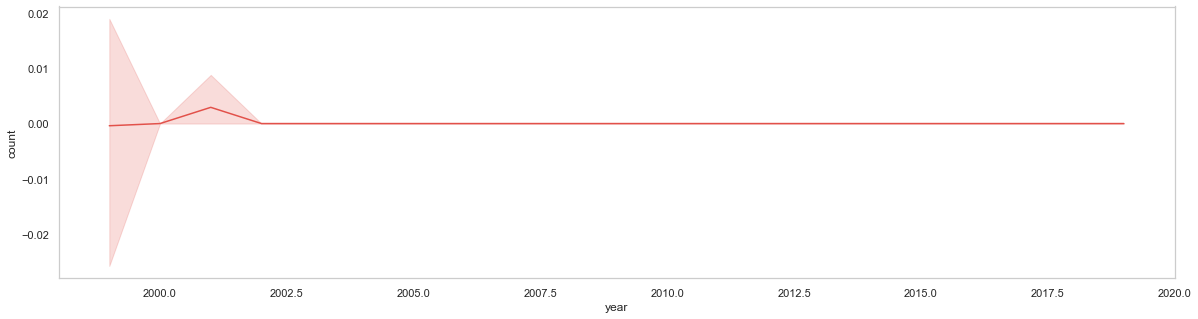

In [38]:
sns.set_palette("Spectral")
sns.lineplot('year', 'count', data=cve)

In [39]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(cve['count'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -295.9882552959502
p-value: 0.0
